In [1]:
%matplotlib inline
import matplotlib
import numpy as np
from numpy import genfromtxt
import scipy.misc
import matplotlib.pyplot as plt
import sklearn.datasets
import theano
import theano.tensor as T
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from keras.layers import advanced_activations, normalization
from keras.optimizers import *
from keras.layers.advanced_activations import *
import csv
import pickle

Using Theano backend.


In [2]:
IMAGE_WIDTH = 96
IMAGE_HIGHT = 96
CHANNELS_NUM = 1
DATASET_SIZE = 7049
CLASSES_NUM = 15*2
EPOCHS_NUM = 500
BATCH_SIZE = 16
LEARNING_RATE = 0.001
FILE_NAME = 'CSVs/facial_points_training.csv'

In [11]:
def load_data():

    X_data = np.zeros((DATASET_SIZE, IMAGE_HIGHT*IMAGE_WIDTH))
    
    Y_data = genfromtxt(FILE_NAME, delimiter = ',')[1:, :CLASSES_NUM]
#     my_test_ = genfromtxt('test.csv', delimiter = ',')
    
    with open(FILE_NAME, 'rb') as csvfile:
        reader = csv.DictReader(csvfile)
        for i, row in enumerate(reader):
            X_data[i, :] = np.fromstring(row['Image'], dtype=int, sep=' ')
            
    X_data = X_data.reshape((-1, IMAGE_HIGHT, IMAGE_WIDTH, CHANNELS_NUM))
    
    mask = np.random.choice(DATASET_SIZE, int((4.0/5)*DATASET_SIZE), False)     #Random numbers must be unique.
    X_train = X_data[mask, :, :, :] 
    Y_train = Y_data[mask]
    X_val_tst = X_data[~mask, :, :, :] 
    Y_val_tst = Y_data[~mask]
    val_mask = np.random.choice(X_val_tst.shape[0], int((1.0/10)*DATASET_SIZE), False)
    X_valid = X_val_tst[val_mask, :, :, :]
    X_test = X_val_tst[~val_mask, :, :, :]
    Y_valid = Y_val_tst[val_mask]
    Y_test = Y_val_tst[~val_mask]
    
    print X_train.shape, X_valid.shape, X_test.shape
    print Y_train.shape, Y_valid.shape, Y_test.shape

    return dict(
        X_train=X_train.astype(theano.config.floatX),
        y_train=Y_train.astype('int32'),
        X_valid=X_valid.astype(theano.config.floatX),
        y_valid=Y_valid.astype('int32'),
        X_test=X_test.astype(theano.config.floatX),
        y_test=Y_test.astype('int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=CLASSES_NUM,)

(5639, 96, 96, 1) (704, 96, 96, 1) (704, 96, 96, 1)
(5639, 30) (704, 30) (704, 30)


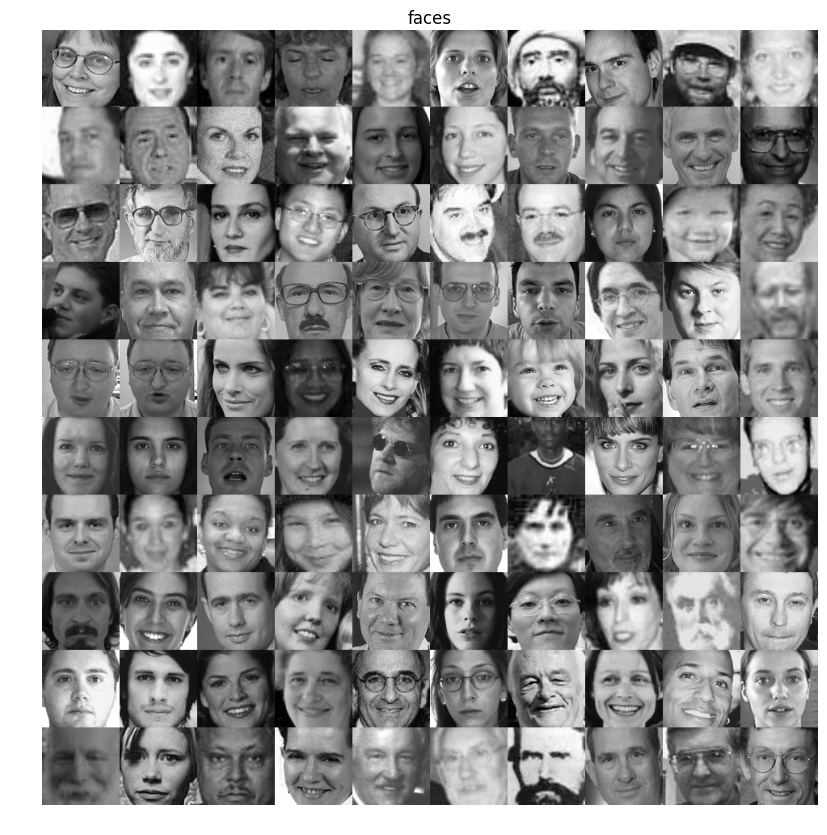

In [12]:
data = load_data()

idx = 0
canvas = np.zeros((IMAGE_HIGHT*10, 10*IMAGE_WIDTH))
for i in range(10):
    for j in range(10):
        canvas[i*IMAGE_HIGHT:(i+1)*IMAGE_HIGHT, j*IMAGE_WIDTH:(j+1)*IMAGE_WIDTH] = data['X_train'][idx].reshape((IMAGE_HIGHT, IMAGE_WIDTH))
        idx += 1
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')
plt.title('faces')
plt.axis('off')

plt.show()

In [24]:
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle


FTRAIN = 'CSVs/facial_points_training.csv'
FTEST = '~/data/kaggle-facial-keypoint-detection/test.csv'


def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(fname)  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values)  
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [25]:
def build_model():
    model = Sequential()
    
    model.add(Convolution2D(16, 3, 3, init = 'he_normal', border_mode='same', input_shape=(IMAGE_HIGHT, IMAGE_WIDTH, CHANNELS_NUM)))
    model.add(normalization.BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))
    model.add(Convolution2D(16, 3, 3, init = 'he_normal', border_mode='same'))
    model.add(normalization.BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))
    model.add(Convolution2D(8, 1, 1, init = 'he_normal', border_mode='same'))
    model.add(normalization.BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(64, init = 'he_normal'))
    model.add(normalization.BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.4))

    model.add(Dense(CLASSES_NUM, init = 'he_normal'))
    model.add(Activation('linear'))
    return model

In [26]:
inzeption = build_model()
inzeption.summary()
adam = Adam(lr=LEARNING_RATE, decay=0.0001)
inzeption.compile(optimizer=adam, loss='mse')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_12 (Convolution2D) (None, 96, 96, 16)    160         convolution2d_input_5[0][0]      
____________________________________________________________________________________________________
batchnormalization_15 (BatchNorm (None, 96, 96, 16)    32          convolution2d_12[0][0]           
____________________________________________________________________________________________________
leakyrelu_15 (LeakyReLU)         (None, 96, 96, 16)    0           batchnormalization_15[0][0]      
____________________________________________________________________________________________________
dropout_15 (Dropout)             (None, 96, 96, 16)    0           leakyrelu_15[0][0]               
___________________________________________________________________________________________

In [ ]:
try:
    inzeption.fit(data['X_train'], data['y_train'], batch_size=32, nb_epoch=100)
except KeyboardInterrupt:
    pass

Epoch 1/100
5639/5639 [==============================] - 340s - loss: 2312576441284002816.0000   
Epoch 2/100
2336/5639 [===========>..................] - ETA: 208s - loss: 2311633995752785920.0000